In [1]:
!nvidia-smi

Mon Jul 13 08:52:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 64%   66C    P0    74W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 33%   47C    P0    66W / 250W |      0MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
torch.Tensor(6)

tensor([4.2039e-45, 2.6709e-42, 6.8374e-40, 1.8206e-34, 2.5353e+30, 1.1210e-44])

In [5]:
from not_darts_yet import Not_darts_yet

net = Not_darts_yet(C=36,num_classes=10,num_layers=8)



In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [7]:
net.to(device)

Not_darts_yet(
  (extractor): Sequential(
    (0): Conv2d(3, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layers): ModuleList(
    (0): NormalCell(
      (preproc_pp): ReLUConvBN(
        (op): Sequential(
          (0): ReLU()
          (1): Conv2d(108, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (preproc_p): ReLUConvBN(
        (op): Sequential(
          (0): ReLU()
          (1): Conv2d(108, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (ops): ModuleList(
        (0): ModuleList(
          (0): SepConv(
            (op): Sequential(
              (0): ReLU()
              (1): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1)

In [8]:
import torch.optim as optim
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [9]:
from tqdm import tqdm

num_classes = 10
trn_loss_list = []
val_loss_list = []
acc_list = []
acc_list_aug = []
num_batches=len(trainloader)
total_epoch = 10

for epoch in range(total_epoch):   # 데이터셋을 수차례 반복합니다.
    net.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0),total=len(trainloader)):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    net.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(num_classes))
        class_total = list(0. for i in range(num_classes))
        correct = 0
        total = 0
        for j,val in enumerate(testloader):
            v1 = val[0].to(device)
            val_labels = val[1].to(device)
            val_output = net(v1)
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss
            _, predicted = torch.max(val_output, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        print("epoch:",str(epoch))
        temp_acc = []
        for i in range(num_classes):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
                temp_acc.append(100 * class_correct[i] / class_total[i])
        acc_list.append(temp_acc)

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, total_epoch, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0

print('Finished Training')

100%|██████████| 391/391 [00:28<00:00, 13.94it/s]


epoch: 0
Accuracy of     0 : 67 %
Accuracy of     1 : 57 %
Accuracy of     2 : 57 %
Accuracy of     3 : 38 %
Accuracy of     4 : 21 %
Accuracy of     5 : 60 %
Accuracy of     6 : 42 %
Accuracy of     7 : 57 %
Accuracy of     8 : 56 %
Accuracy of     9 : 60 %
epoch: 1/10 | step: 10/391 | trn loss: 1.4657 | val loss: 1.3191
Accuracy of the network on the test images: 51 %


100%|██████████| 391/391 [00:26<00:00, 14.84it/s]


epoch: 1
Accuracy of     0 : 57 %
Accuracy of     1 : 86 %
Accuracy of     2 : 50 %
Accuracy of     3 : 35 %
Accuracy of     4 : 59 %
Accuracy of     5 : 47 %
Accuracy of     6 : 56 %
Accuracy of     7 : 84 %
Accuracy of     8 : 58 %
Accuracy of     9 : 72 %
epoch: 2/10 | step: 10/391 | trn loss: 1.0515 | val loss: 1.1236
Accuracy of the network on the test images: 60 %


100%|██████████| 391/391 [00:28<00:00, 13.90it/s]


epoch: 2
Accuracy of     0 : 78 %
Accuracy of     1 : 88 %
Accuracy of     2 : 63 %
Accuracy of     3 : 51 %
Accuracy of     4 : 53 %
Accuracy of     5 : 47 %
Accuracy of     6 : 70 %
Accuracy of     7 : 75 %
Accuracy of     8 : 82 %
Accuracy of     9 : 66 %
epoch: 3/10 | step: 10/391 | trn loss: 0.8855 | val loss: 0.9100
Accuracy of the network on the test images: 67 %


100%|██████████| 391/391 [00:27<00:00, 14.42it/s]


epoch: 3
Accuracy of     0 : 75 %
Accuracy of     1 : 70 %
Accuracy of     2 : 50 %
Accuracy of     3 : 72 %
Accuracy of     4 : 53 %
Accuracy of     5 : 52 %
Accuracy of     6 : 69 %
Accuracy of     7 : 82 %
Accuracy of     8 : 87 %
Accuracy of     9 : 86 %
epoch: 4/10 | step: 10/391 | trn loss: 0.7813 | val loss: 0.8469
Accuracy of the network on the test images: 69 %


100%|██████████| 391/391 [00:26<00:00, 14.81it/s]


epoch: 4
Accuracy of     0 : 74 %
Accuracy of     1 : 81 %
Accuracy of     2 : 66 %
Accuracy of     3 : 64 %
Accuracy of     4 : 57 %
Accuracy of     5 : 51 %
Accuracy of     6 : 88 %
Accuracy of     7 : 64 %
Accuracy of     8 : 84 %
Accuracy of     9 : 90 %
epoch: 5/10 | step: 10/391 | trn loss: 0.6995 | val loss: 0.7918
Accuracy of the network on the test images: 72 %


100%|██████████| 391/391 [00:25<00:00, 15.11it/s]


epoch: 5
Accuracy of     0 : 82 %
Accuracy of     1 : 96 %
Accuracy of     2 : 66 %
Accuracy of     3 : 56 %
Accuracy of     4 : 58 %
Accuracy of     5 : 57 %
Accuracy of     6 : 87 %
Accuracy of     7 : 62 %
Accuracy of     8 : 84 %
Accuracy of     9 : 62 %
epoch: 6/10 | step: 10/391 | trn loss: 0.6308 | val loss: 0.8303
Accuracy of the network on the test images: 71 %


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


epoch: 6
Accuracy of     0 : 80 %
Accuracy of     1 : 85 %
Accuracy of     2 : 80 %
Accuracy of     3 : 66 %
Accuracy of     4 : 73 %
Accuracy of     5 : 34 %
Accuracy of     6 : 64 %
Accuracy of     7 : 75 %
Accuracy of     8 : 85 %
Accuracy of     9 : 88 %
epoch: 7/10 | step: 10/391 | trn loss: 0.5758 | val loss: 0.7611
Accuracy of the network on the test images: 73 %


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


epoch: 7
Accuracy of     0 : 74 %
Accuracy of     1 : 85 %
Accuracy of     2 : 58 %
Accuracy of     3 : 62 %
Accuracy of     4 : 47 %
Accuracy of     5 : 62 %
Accuracy of     6 : 90 %
Accuracy of     7 : 71 %
Accuracy of     8 : 91 %
Accuracy of     9 : 91 %
epoch: 8/10 | step: 10/391 | trn loss: 0.5295 | val loss: 0.7937
Accuracy of the network on the test images: 73 %


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


epoch: 8
Accuracy of     0 : 80 %
Accuracy of     1 : 92 %
Accuracy of     2 : 71 %
Accuracy of     3 : 43 %
Accuracy of     4 : 78 %
Accuracy of     5 : 74 %
Accuracy of     6 : 81 %
Accuracy of     7 : 76 %
Accuracy of     8 : 91 %
Accuracy of     9 : 80 %
epoch: 9/10 | step: 10/391 | trn loss: 0.4876 | val loss: 0.6865
Accuracy of the network on the test images: 76 %


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


epoch: 9
Accuracy of     0 : 88 %
Accuracy of     1 : 93 %
Accuracy of     2 : 55 %
Accuracy of     3 : 66 %
Accuracy of     4 : 72 %
Accuracy of     5 : 54 %
Accuracy of     6 : 83 %
Accuracy of     7 : 85 %
Accuracy of     8 : 82 %
Accuracy of     9 : 82 %
epoch: 10/10 | step: 10/391 | trn loss: 0.4538 | val loss: 0.7089
Accuracy of the network on the test images: 76 %
Finished Training


No handles with labels found to put in legend.


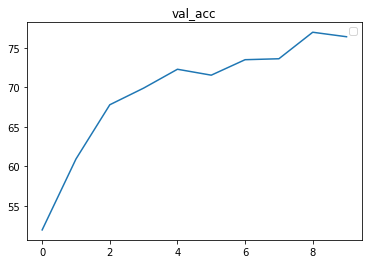

No handles with labels found to put in legend.


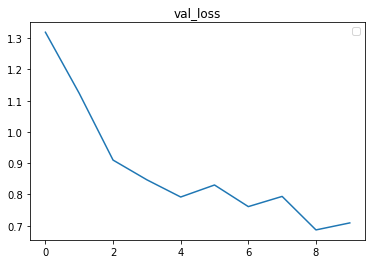

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('val_acc')
plt.plot([np.mean(x) for x in acc_list])
plt.legend()
plt.show()
plt.title('val_loss')
plt.plot(val_loss_list)
plt.legend()
plt.show()